# Projet TAL M1 S1 : POS Tagging
structure du projet expliqué ici : https://u-paris.zoom.us/rec/share/rFB-gp7vkgMK31kfPxEsyNF2k6q7mHcq3P9MQiovimkr9ebIewZpuD62RBk6SmM.31Mmzx1VyMqQXRtu?startTime=1607605609000

# Implémentation du classifieur

## Import du corpus

On charge les trois corpus *in-domain* sous la forme de listes de dictionnaires : chaque phrase a une clé "mots" qui est associée à une liste des mots, et une clé "POS" associée à une liste de POS. 

On utilise les trois corpus distincts de French-GSD :
- Train : apprentissage.
- Dev : validation. Pour tester et améliorer le modèle. 
- Test : évaluation. On ne l'utilisera pas pendant l'apprentissage ou les tests.

In [2]:
def load_corpus(file):
    with open(file, "r", encoding = "utf8") as f: 
        content = f.read() # chargement du corpus
    content = content.split("\n\n") # séparation en phrases
    corpus = []
    for phrase in content: # pour chaque phrase
        phrase_dico = {"mots" : [], "gold_labels" : []} # liste qui contiendra 1 dictionnaire par mot de la phrase
        for line in phrase.splitlines():
            if not line.startswith("#"): # on ignore les lignes qui commencent par #
                features = line.split("\t")
                phrase_dico["mots"].append(features[1])
                # phrase_dico["lemme"].append(features[2])
                phrase_dico["gold_labels"].append(features[3])
        corpus.append(phrase_dico)
    return corpus

gsd_train = load_corpus("corpus-in-domain/fr_gsd-ud-train.conllu")
gsd_test = load_corpus("corpus-in-domain/fr_gsd-ud-test.conllu")
gsd_dev = load_corpus("corpus-in-domain/fr_gsd-ud-dev.conllu")

In [3]:
print("---- Aperçus d'une phrase de chaque corpus-----", end="\n\n")
print(gsd_train[1], end="\n\n")
print(gsd_test[102], end="\n\n")
print(gsd_dev[564])

---- Aperçus d'une phrase de chaque corpus-----

{'mots': ["L'", 'œuvre', 'est', 'située', 'dans', 'la', 'galerie', 'des', 'de', 'les', 'batailles', ',', 'dans', 'le', 'château', 'de', 'Versailles', '.'], 'gold_labels': ['DET', 'NOUN', 'AUX', 'VERB', 'ADP', 'DET', 'NOUN', '_', 'ADP', 'DET', 'NOUN', 'PUNCT', 'ADP', 'DET', 'NOUN', 'ADP', 'PROPN', 'PUNCT']}

{'mots': ['La', 'gestion', 'et', "l'", 'exploitation', 'de', 'la', 'salle', 'de', 'concert', 'Wagram', ',', 'récemment', 'rénovée', ',', 'sera', 'assurée', 'par', 'Eurosites', ',', 'leader', 'en', 'France', 'de', 'la', 'location', 'de', 'salles', '.'], 'gold_labels': ['DET', 'NOUN', 'CCONJ', 'DET', 'NOUN', 'ADP', 'DET', 'NOUN', 'ADP', 'NOUN', 'PROPN', 'PUNCT', 'ADV', 'VERB', 'PUNCT', 'AUX', 'VERB', 'ADP', 'PROPN', 'PUNCT', 'NOUN', 'ADP', 'PROPN', 'ADP', 'DET', 'NOUN', 'ADP', 'NOUN', 'PUNCT']}

{'mots': ['Cette', 'espèce', 'est', 'endémique', 'du', 'de', 'le', 'département', 'de', 'Nariño', 'en', 'Colombie', '.'], 'gold_labels': ['DET'

## Extraction des caractéristiques

La fonction feature_extraction renvoie une liste de dictionnaires (un par mot) qui contiennent les caractéristiques suivantes pour chaque mot :
- mot
- mot précédent : pour le premier mot de la phrase son mot précédent sera "START", ce qui permettra de prendre en compte la caractéristique "être le premier mot".
- mot suivant : pour le dernier mot, ce sera "END".
- commence par une lettre majuscule
- est entièrement en majuscules
- contient des chiffres
- contient des caractères non alphanumériques
- longueur du mot (3 caractéristiques binaires) : a 1 seule caractère, a moins de 3 caractères, a plus de 3 caractères.
- a un suffixe nominal
- a un suffixe adjectival
- a un suffixe verbal
- a un suffixe adverbial

On ne conserve plus la structure des phrases, qui n'est plus nécessaire une fois qu'on a extrait les informations comme mot précédent et mot suivant.

Ces caractéristiques sont encodées sous la forme d'un dictionnaire pour chaque mot dont les clés désignent les caractéristiques ("mot - commotions", "prec - les", "long", "suff_nom", etc. ) et les valeurs valent 1 quand la caractéristique est vraie pour ce mot. Si la caractéristique n'est pas vraie, alors on n'ajoute pas cette entrée dans le dictionnaire, ce qui permettrait d'optimiser l'apprentissage et la prédiction ensuite.

On a ajouté des booléens pour les différentes catégorie de caractéristiques (mots, majuscules, longueur, caractères non alphabétique et suffixes) qui sont pas défaut True et qu'on utilisera plus tard pour tester l'utilité de ces caractéristiques.

In [4]:
def feature_extraction(corpus, feat_mots=True, feat_maj=True, feat_non_alpha=True, feat_long=True, feat_suff=True):

    corpus_features = []
    """
    Listes à utiliser pour les lemmes :
    list_adj = ["ain", "aine","aire","é", "ée","iel", "uel", "lle",  "al", "ales", "al", "ial","er", "ère", "ier", "esque", "eur", "euse", "ieux","ueux", "if","ive", "in","ine","ique","atoire", "u","ue", "issime", "able","ible", "uble", "ième","uple"]
    list_noun = ["ade", "age","aille", "aison", "ison","oison", "ation", "ition","ssion", "sion","xion", "isation","ment", "ement","erie", "ure","ature","at", "ance","ence", "escence","ité", "eté","té", "ie","erie", "esse","ise", "eur","isme", "iste", "seur", "isseur", "isateur", "euse","isseuse", "atrice","ier","ière", "aire","ien", ienne","iste",er","eron","eronne","trice","oir", "oire","ier","ière","erie","anderie", "aire","ain","aille", "ée", "ard","asse", "assier","âtre","aut","eau","ceau", "ereau","eteau", "elle", "et","elet","ette", 
"elette","in","otin", "ine" "illon","on", "ille", "erole","ole","iche"]
    """

    list_vb = ["iser","ifier", "oyer","ailler", "asser","eler", "eter","iller", "iner","nicher", "ocher","onner","otter","oter", "ouiller"]
    list_adj = ["ain", "aine","ains", "aines","aire", "aires","é", "ée","ées", "és","iel", "iels","uel", "uels", 
"lle", "lles","els", "el" "al", "ales", "al", "ial", "aux","iaux", "er","ers", "ère","ères", "ier", "iers",      "esque","esques", "eur","eurs", "euse","euses", "ieux","ueux", "if", "ifs","ive", "ives","in", "ins","ine",      "ines","iques", "ique","atoire", "u","ue", "us","ues", "issime","issimes","able","ible", "ibles","ables",  
    "uble","ubles", "ième","ièmes", "uple"]
    list_noun = ["ade", "ades", "age", "ages","aille", "ailles", "aison", "ison", "isons","oison", "ation", "itions", "ition", "ssion", "sion","xion", "isation","ment", "ement","erie", "eries","ure","ures","ature", "atures","at", "ance","ence", "escence","ité", "eté","té", "ie","erie", "esse", "ise", "eur","isme", "iste", "istes","eurs", "seur","seurs", "isseur","isseurs", "isateur","euse", "euses","isseuse", "isseuses",       "atrice", "atrices","ier", "iers","ière", "ières","aire","aires","ien", "iens","ienne", "iennes","iste",         "istes","er", "ers","eron", "erons","eronne","trice","oir", "oire","oires", "oirs","ier", "iers","ière",         "ières","erie","eries","anderie","aire", "aires","ain", "aines", "ée","ées","aille", "ard","asse", "asses", "assier","âtre","aut","eau", "eaux","ceau", "ereau","eteau", "elle","elles", "et","elet","ets","ette","elette","ettes", "elettes","in", "ins","otin", "ine","ines", "illon","on","ons","ille", "erole","eroles", "ole","oles", "iche"]

    for phrase in corpus: # ajout des features additionnelles
        for prev, word, suiv in zip(["START"] + phrase["mots"][:-1], phrase["mots"], phrase["mots"][1:] + ["END"]):
            # création de triplets (mot précédent, mot, mot suivant)
            # avec "START" en prev pour le 1er mot
            # et "END" en suiv pour le dernier

            # dictionnaire de features du mot
            if feat_mots :
                features_mot = { 
                    # on récupère le gold_label correspondant
                    f"mot - {word}" : 1,
                    f"prec - {prev}" : 1,
                    f"mot_suiv - {suiv}" : 1,
                    }
            else:
                features_mot = {}
            
            if feat_maj:
                if word.istitle(): features_mot["maj"] = 1 
                if word.isupper(): features_mot["all_caps"] = 1

            if feat_non_alpha:
                if any(char.isdigit() for char in word): features_mot["num"] = 1# mieux que isnumeric(), car renvoie false si espace (40 000) ou virgule (50,6) par ex
                if not word.isalnum(): features_mot["nonAlphanum"] = 1

            if feat_long:
                if len(word) <= 3: features_mot["court"] = 1 
                if len(word) > 3: features_mot["long"] = 1
                if len(word) == 1: features_mot["un_car"] = 1
            
            if feat_suff:
                if word.endswith("ment"): features_mot["suff_adv"] = 1
                if any(word.endswith(elem) and len(word) != len(elem) for elem in list_noun): features_mot["suff_noun"] =1 
                if any(word.endswith(elem) and len(word) != len(elem) for elem in list_adj): features_mot["suff_adj"] = 1
                if any(word.endswith(elem) for elem in list_vb): features_mot["suff_vb"] = 1
                # on vérifie la longueur du mot pour être sûr que ce soit un suffixe car on peut avoir le mot                      age avec le suffixe age par exemple ou bien aux
                # suff_noun : any(lemma.endswith(elem) and len(word) != len(elem) for elem in list_noun),
                # suff_adj : any(lemma.endswith(elem) for elem in list_adj),
                # suff_vb : any(lemma.endswith(elem) for elem in list_vb)
            
            # ajout au corpus
            corpus_features.append(features_mot)

    return corpus_features # renvoie les features transformés en vecteurs one-hot


In [5]:
gsd_train_features = feature_extraction(gsd_train)
print(len(gsd_train_features))
print(*gsd_train_features[10:15], sep="\n")

364349
{"mot - qu'": 1, 'prec - sport': 1, 'mot_suiv - on': 1, 'nonAlphanum': 1, 'court': 1}
{'mot - on': 1, "prec - qu'": 1, 'mot_suiv - les': 1, 'court': 1}
{'mot - les': 1, 'prec - on': 1, 'mot_suiv - considére': 1, 'court': 1}
{'mot - considére': 1, 'prec - les': 1, 'mot_suiv - presque': 1, 'long': 1}
{'mot - presque': 1, 'prec - considére': 1, 'mot_suiv - comme': 1, 'long': 1, 'suff_adj': 1}


In [6]:
def add_gold(features, corpus, addMot=False):
    '''Ajoute les gold labels pour créer un corpus d'entraînement / de test'''
    i = 0
    gold_corpus = []
    for phrase in corpus:
        for word, pos_gold in zip(phrase["mots"],phrase["gold_labels"]):
            if addMot:
                gold_corpus.append((features[i], pos_gold, word))
            else:
                gold_corpus.append((features[i], pos_gold))
            i += 1

    return gold_corpus

In [7]:
gsd_train_features_gold = add_gold(gsd_train_features, gsd_train)
print(*gsd_train_features_gold[100:110], sep="\n")

({'mot - avec': 1, 'prec - reviendrais': 1, 'mot_suiv - plaisir': 1, 'long': 1}, 'ADP')
({'mot - plaisir': 1, 'prec - avec': 1, 'mot_suiv - !': 1, 'long': 1}, 'NOUN')
({'mot - !': 1, 'prec - plaisir': 1, 'mot_suiv - END': 1, 'nonAlphanum': 1, 'court': 1, 'un_car': 1}, 'PUNCT')
({'mot - Les': 1, 'prec - START': 1, 'mot_suiv - forfaits': 1, 'maj': 1, 'court': 1}, 'DET')
({'mot - forfaits': 1, 'prec - Les': 1, 'mot_suiv - comprennent': 1, 'long': 1}, 'NOUN')
({'mot - comprennent': 1, 'prec - forfaits': 1, 'mot_suiv - le': 1, 'long': 1}, 'VERB')
({'mot - le': 1, 'prec - comprennent': 1, 'mot_suiv - transport': 1, 'court': 1}, 'DET')
({'mot - transport': 1, 'prec - le': 1, 'mot_suiv - en': 1, 'long': 1}, 'NOUN')
({'mot - en': 1, 'prec - transport': 1, 'mot_suiv - car': 1, 'court': 1}, 'ADP')
({'mot - car': 1, 'prec - en': 1, 'mot_suiv - Grand': 1, 'court': 1}, 'NOUN')


## Implémentation de l'algorithme de classification
On a choisi d'implémenter la classification avec un perceptron moyenné.

La fonction predict sera utilisée à la fois dans l'apprentissage et dans la "prédiction". Elle correspond à la recherche de l'étiquette avec le plus grand score (argmax...)

In [8]:
def predict(word_features, weights):
    """Renvoie l'étiquette avec le plus gros score (argmax)"""
    scores = {}
    for tag, w in weights.items():
        scores[tag] =  sum(word_features.get(feat)*w.get(feat, 0) for feat in word_features)
    #print(scores)

    return max(scores, key=scores.get)

In [19]:
from random import shuffle

def perceptron_train(training_set, MAX_EPOCH=3):
    
    tags = ["ADJ", "ADP", "ADV", "AUX", "CCONJ", "DET", "INTJ", "NOUN", "NUM", "PART", "PRON", "PROPN", "PUNCT", "SCONJ", "SYM", "VERB", "X"]

    # initialisation de a (poids totaux)
    a = {}
    for tag in tags:
        a[tag] = {}

    # initialisation des vecteurs de poids
    w = {}
    for tag in tags:
        w[tag] = {}
    
    for i in range(0, MAX_EPOCH):
        shuffled_set = training_set.copy() # copie du training set
        shuffle(shuffled_set) # mélange du training set

        for word in shuffled_set:
            vec = word[0]
            gold = word[1]
            prediction = predict(vec, w) # trouve étiquette plus probable avec les poids w
            if not gold == "_" and not prediction == gold: # si le gold_label n'est pas égal à celui prédit
                # on ignore les mots dont le gold_label est "_" ("au" et "du") car ils sont ensuite analysés comme "à le" et "de le"
                for feat in vec: # pour chaque feature du mot
                    w[gold][feat] = w[gold].get(feat,0) + vec.get(feat) #  on ajoute x(i) à chaque poids de l'étiquette correcte
                    w[prediction][feat] = w[prediction].get(feat,0) - vec[feat] #  on retire x(i) à chaque poids de l'étiquette mal prédite
        
    # on ajoute w à a
        for tag in w:
            for index in w[tag].keys(): 
                a[tag][index] = a[tag].get(index, 0) + w[tag][index]

    return a


In [10]:
poids_gsd_train = perceptron_train(gsd_train_features_gold)

# Evaluation des performances sur le corpus de validation (Dev)
La fonction test() renvoie le taux d'erreur sur un corpus en utilisant la fonction predict() avec les poids issus de l'apprentissage. On effectue ce test sur le corpus dev avec différents nombres d'itération à l'apprentissage pour voir l'impact des itérations sur ce taux d'erreur.

In [11]:
gsd_dev_features = feature_extraction(gsd_dev)
gsd_dev_features_gold = add_gold(gsd_dev_features, gsd_dev)


def test(corpus, poids):
    """Prédit les étiquettes et renvoie un taux d'erreur"""
    nb_erreurs = 0
    # output = open("test.txt", "w")
    # output.write("MOT\tPREDICT\tGOLD\tRESULTAT\n")
    for word in corpus:
        vec = word[0]
        gold = word[1]
        prediction = predict(vec, poids)
       # print(f"{vec}\t{prediction}\t{gold}\t")
        if not gold == "_" and not prediction == gold:
            nb_erreurs +=1
            #output.write("ERREUR")
        #else:
            #output.write("OK")
        #output.write("\n")
    
    #output.write(f"Nombre d\'erreurs : {nb_erreurs}")
    #output.write(f"\nTaux d\'erreur : {nb_erreurs/len(corpus)}")
    #output.close()

    return nb_erreurs/len(corpus)

In [20]:
taux = []
x_range = range(1, 7)

for i in x_range:
    poids_gsd_train = perceptron_train(gsd_train_features_gold, MAX_EPOCH=i)
    tx_erreur = test(gsd_dev_features_gold, poids_gsd_train)
    taux.append(tx_erreur)
    print(f"{i} itérations : {tx_erreur:.3%} d'erreurs")

1 itérations : 7.568% d'erreurs
2 itérations : 4.914% d'erreurs
3 itérations : 4.343% d'erreurs
4 itérations : 4.506% d'erreurs
5 itérations : 3.886% d'erreurs
6 itérations : 3.905% d'erreurs


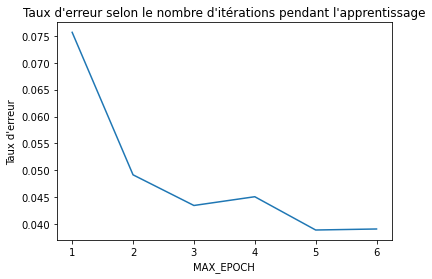

In [21]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(x_range,taux)
plt.ylabel("Taux d'erreur")
plt.xlabel("MAX_EPOCH")
plt.title("Taux d'erreur selon le nombre d'itérations pendant l'apprentissage")
plt.show()

On remarque qu'à partir de 2 ou 3 itérations on descend en dessous de 5% d'erreurs, mais que des itérations additionnelles n'améliorent pas beaucoup ce taux, en tout cas pas assez par rapport au temps additionnel que demande l'entraînement avec ces itérations additionnelles. Nous choisissont donc 3 itérations par défaut.

### Evaluation des caractéristiques
On peut se demander si on pourrait obtenir des taux similaires avec moins de features, si certaines features apportent plus de précision que d'autre. Pour cela on réeffectue un apprentissage avec 3 itérations, sans modifier l'extraction de caractéristiques. Puis on teste différentes combinaisons d'extractions de features sur le corpus dev avant d'effectuer le test : seulement les mots (mot, mot précédent et mot suivant), et tout sauf les mots. On pourrait bien sûr tester bien d'autres combinaisons. Les features non extraites sur le corpus dev valent donc toutes zéro pour ce corpus et ne seront pas prises en compte.

In [22]:
poids_gsd_train = perceptron_train(gsd_train_features_gold) # entraînement avec nombre d'itérations par défaut

In [85]:
def test_features(corpus, poids, test_mots=False, test_maj=False, test_non_alpha=False, test_long=False, test_suff=False):
    '''Effectue les 3 étapes nécessaires pour effectuer le test'''
    features = feature_extraction(corpus, feat_mots=test_mots, feat_maj=test_maj, feat_non_alpha=test_non_alpha, feat_long=test_long, feat_suff=test_suff)
    features_gold = add_gold(features, corpus)
    tx_erreur = test(features_gold, poids)
    
    return tx_erreur

print(f"Test avec seulement les mots : {test_features(gsd_train, poids_gsd_train, test_mots=True):.3%}")
print(f"Test avec tout sauf les mots : {test_features(gsd_train, poids_gsd_train, test_maj=True, test_suff=True, test_non_alpha=True, test_long=True):.3%}")

Test avec seulement les mots : 9.619%
Test avec tout sauf les mots : 69.782%


On remarque que sans la prise en compte des mots le résultat est catastrophique ! Avec seulement les mots on fait environ 2 fois plus d'erreurs que si on prend en compte l'ensemble des caractéristiques. Tester quelques combinaisons de mots + autres caractéristiques :

In [34]:
print(f"Test avec mots + longueur : {test_features(gsd_train, poids_gsd_train, test_mots=True, test_long=True):.3%}")
print(f"Test avec mots + maj : {test_features(gsd_train, poids_gsd_train, test_mots=True, test_maj=True):.3%}")
print(f"Test avec mots + caractères non alphanumériques : {test_features(gsd_train, poids_gsd_train, test_mots=True, test_non_alpha=True):.3%}")
print(f"Test avec mots + suffixes : {test_features(gsd_train, poids_gsd_train, test_mots=True, test_suff=True):.3%}")

Test avec mots + longueur : 9.943%
Test avec mots + maj : 6.233%
Test avec mots + caractères non alphanumériques : 8.480%
Test avec mots + suffixes : 9.355%


A partir de ces tests non exhaustifs, il semblerait que la prise en compte des majuscules apporte davantage de précision, tandis que la prise en compte des autres caractéristiques seules, en plus des mots, apporte beaucoup moins de précision et pourrait peut-être être éliminés.

### Erreurs fréquentes
On peut analyser les erreurs les plus fréquentes à l'aide d'une matrice de confusion.

In [36]:
# matrice de confusion avec Pandas. source : https://stackoverflow.com/questions/2148543/how-to-write-a-confusion-matrix-in-python

import pandas as pd

def matrice_confusion(corpus_feat, poids):
    predictions = []
    gold = []

    for word in corpus_feat:
        predictions.append(predict(word[0], poids))
        gold.append(word[1])

    preds = pd.Series((item for item in predictions), name = "Prédictions")
    refs = pd.Series((item for item in gold), name = "Références")
    matrice_confusion = pd.crosstab(refs, preds, margins=True)
    print(matrice_confusion)

matrice_confusion(gsd_dev_features_gold, poids_gsd_train)

Prédictions   ADJ   ADP   ADV   AUX  CCONJ   DET  INTJ  NOUN  NUM  PART  PRON  \
Références                                                                      
ADJ          1739     0     8     0      0     6     0   124    6     0    15   
ADP             0  5729     0     2      0     5     0     1    0     0     0   
ADV            13     7  1234     6      1     0     0     9    0     0     0   
AUX             1     0     2  1080      0     0     0     5    0     0     0   
CCONJ           0     0     4     1    879     0     0     0    0     0     0   
DET             5    28     1     0      0  5467     0     1    6     0     4   
INTJ            0     0     1     0      0     0     3     0    0     0     0   
NOUN           66     1    11     6      1     3     1  6297    6     0     2   
NUM             0     0     0     0      0     7     0     3  938     0     0   
PART            0     0     2     0      0     0     0     0    0     6     0   
PRON            8    10     

Les erreurs les plus fréquentes sont :
- VERB au lieu d'ADJ (234)
- PROPN au lieu de NOUN (217)
- NOUN au lieu d'ADJ (124)
- NOUN au lieu de SYM
- VERB au lieu de NOUN (102)

### Précision sur mots hors vocabulaire d'apprentissage
Comparons la précision sur les mots présents dans le corpus d'apprentissage et ceux absents du corpus d'apprentissage.

In [86]:
def getVoc(corpus):
    '''Renvoie le vocabulaire (set)'''
    voc = set()
    for phrase in corpus:
        for mot in phrase["mots"]:
            voc.add(mot)
    return voc

def test_hors_voc(features_gold_mot, poids, voc):
    """Prédit les étiquettes des mots hors vocabulaire et renvoie un taux d'erreur"""
    nb_erreurs_hors_voc = 0
    nb_erreurs_in_voc = 0

    mots_hors_voc=0
    mots_in_voc = 0

    for vec, gold, mot in features_gold_mot:
        if mot in voc:
            mots_in_voc +=1
            prediction = predict(vec, poids)
            if not gold == "_" and not prediction == gold:
                nb_erreurs_in_voc +=1
        else:
            mots_hors_voc +=1
            prediction = predict(vec, poids)
            if not gold == "_" and not prediction == gold:
                # print(mot, vec, prediction, gold, sep="\t", end="\n")
                nb_erreurs_hors_voc +=1


    return (nb_erreurs_hors_voc/mots_hors_voc, nb_erreurs_in_voc/mots_in_voc)

In [87]:
# nouvelle extraction de features mais avec les mots, pour pouvoir ensuite voir s'ils sont dans le vocabulaire ou pas
gsd_dev_features_gold_mot = add_gold(gsd_dev_features, gsd_dev, addMot=True)

resultats_test_voc = test_hors_voc(gsd_dev_features_gold_mot, poids_gsd_train, getVoc(gsd_train))

print(f"Taux d'erreur hors voc : {resultats_test_voc[0]:.3%}")
print(f"Taux d'erreur dans voc : {resultats_test_voc[1]:.3%}")

Taux d'erreur hors voc : 21.043%
Taux d'erreur dans voc : 3.645%


Le taux d'erreur sur les mots non présents dans le vocabulaire d'apprentissage est très élevé (plus de 20%) tandis que celui sur les mots présents dans le vocabulaire d'apprentissage est très bas. Le perceptron se repose beaucoup sur l'association des mots à leur catégorie grammaticale, par rapport aux autres caractéristiques.

## Evaluation sur le corpus Test

In [32]:
gsd_test_features = feature_extraction(gsd_test)
gsd_test_features_gold = add_gold(gsd_test_features, gsd_test)

print(f"Taux d'erreur sur corpus d'évaluation in-domaine : {test(gsd_test_features_gold, poids_gsd_train):.3%}")

Taux d'erreur sur corpus d'évaluation in-domaine : 4.593%


# Evaluation hors-domaine

## Analyse de l'impact du changement de domaine
* identifier causes de la baisse de performance : analyse de sortie, matrice de confusion, erreurs les + fréquentes
* réfléchir à des caractéristiques plus adaptées
* sélection d'un nouvel ensemble d'apprentissage avec des exemples représentatif (généré par un modèle de langue type TP2)

### Corpus UGC (User-generated content)

### Corpus littéraire

## Développement de systèmes robutes au changement de domaine